In [1]:
import tszip
import pandas as pd
import numpy as np
import tszip
import sc2ts
import matplotlib_venn
import matplotlib.pyplot as plt
#import seaborn as sns
from pangonet.pangonet import PangoNet

In [2]:
ds = sc2ts.Dataset("../data/viridian_mafft_2024-10-14_v1.vcz.zip")

2025-10-15 16:17:11,106 INFO:Loading dataset @../data/viridian_mafft_2024-10-14_v1.vcz.zip using None as date field


In [3]:
df_sc2ts = pd.read_csv("../data/recombinants.csv").set_index("recombinant")

In [80]:
pn = PangoNet().build(
    alias_key="../arg_postprocessing/pangonet_data/alias_key.json",
    lineage_notes="../arg_postprocessing/pangonet_data/lineage_notes.txt")

xbb_descendants = pn.get_descendants("XBB")

def compress_xbbs(lin_counts):
    ret = {"XBB": 0}
    for k, v in lin_counts.items():
        if k in xbb_descendants:
            ret["XBB"] += v
        else:
            ret[k] = v
    return ret


def add_x_lineages(df):
    d = {}
    for k, row in df.iterrows():
        d[k] = eval(row["pango_counts"])
        if "XBB" in d[k]:
            d[k] = compress_xbbs(d[k])
    df["pango_counts"] = d
    
    x_lineage_involved = dict()
    for k, row in df.iterrows():
        pango_counts = row["pango_counts"]
        x_lineage_involved[k] = False
        if any(lin.startswith("X") for lin in pango_counts.keys()):
            if len(pango_counts) >= 20:
                print("Filtering messy", pango_counts)
                continue
            if any((lin.startswith("XB") and "." in lin) for lin in pango_counts.keys()):
                # Manually filter out the de-novo XBB ones
                print("Filtering de-novo sub XBBs", pango_counts)
                continue
            x_lineage_involved[k] = True
    # This is a slightly more precise version of the stored one as it filters out 
    # the messy bits above.
    df["x_lineage_involved"] = x_lineage_involved
    
    return df

def read_ripples(path):
    df = pd.read_csv(path,  
                     parse_dates=["recombinant_date", "parent1_date", "parent2_date"],
                     date_format="ISO8601")
    df["max_parent_date"] = np.maximum(df["parent1_date"].values, df["parent2_date"].values)
    df["min_parent_branch_length"] = (df["recombinant_date"] - df["max_parent_date"]).dt.days
    return df.set_index("recombinant")


dfp4 = read_ripples("../arg_postprocessing/sc2ts_viridian_v1.2_ripples_p4.csv")
dfp3 = read_ripples("../arg_postprocessing/sc2ts_viridian_v1.2_ripples_p3.csv")


2025-10-15 17:11:09,077 INFO:Creating aliases.
2025-10-15 17:11:09,080 INFO:Creating network.


In [81]:
np.sum(dfp4["min_parent_branch_length"] <= 0)

np.int64(571)

We're assuming that the p4 is a superset of p3. This is alomost true. Let's ignore the handful of nodes that fail, as they are probably a result of the sampling from the se of events with identical samples.

In [21]:
dfp4.loc[list(set(dfp4.index) - set(dfp3.index))]

,parent1,parent2,recombinant_date,parent1_date,parent2_date,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,sc2ts_num_mutations,x_lineage_involved,usher_num_descendants,min_parent_date,min_parent_branch_length
recombinant,,,,,,,,,,,,,,,
node_182175,SRR19259675,SRR15391358,2021-12-15,2021-12-09,2021-07-16,{'AY.119': 1},894852,1,894853,1,0,False,1,2021-07-16,152
node_267578,SRR15272300,SRR15364261,2021-08-10,2021-07-12,2021-07-19,{'AY.25.1': 2},408173,2,408173,0,1,False,2,2021-07-12,29
node_7017,node_7016,ERR4671078,2020-08-09,2020-08-09,2020-08-26,"{'B.1.160': 2270, 'B.1.160.33': 122, 'B.1.160....",25312,2911,-1,2147483648,12,False,2896,2020-08-09,0
node_547712,node_547711,node_539515,2023-01-22,2023-01-22,2022-10-28,{'XBB.1': 2},1429710,2,1429711,1,0,True,2,2022-10-28,86
node_316747,node_316746,SRR15585202,2021-08-31,2021-08-31,2021-08-09,{'AY.122': 1},471870,1,-1,2147483648,2,False,1,2021-08-09,22
node_112982,ERR6862351,ERR6440908,2021-10-31,2021-09-17,2021-07-26,{'AY.4': 2},698164,2,698164,0,2,False,2,2021-07-26,97
node_562341,ERR10296472,ERR9824329,2022-07-04,2022-09-11,2022-05-19,{'BA.5.1': 2},1288800,2,1288801,1,0,False,2,2022-05-19,46
node_44179,node_323086,node_45166,2021-04-10,2021-03-23,2021-07-31,"{'AY.35': 270, 'B.1.617.2': 2655, 'AY.48': 292}",238161,3219,-1,2147483648,6,False,3217,2021-03-23,18
node_331110,SRR15413985,ERR5965620,2021-09-08,2021-07-31,2021-05-16,{'AY.47': 6},499869,6,499869,0,2,False,6,2021-05-16,115


In [22]:
dfp3["in_p4"] = dfp3.index.isin(dfp4.index)
dfp3["in_p4"].value_counts()

in_p4
False    2949
True     1162
Name: count, dtype: int64

In [23]:
dfp4.shape

(1174, 15)

## 3SEQ validation results

In [24]:
def parse_name(val):
    splits = val.split("_")
    if splits[0].startswith("node"):
        event = "_".join(splits[:2])
    else:
        event = splits[0]
    return event

def read_3seq(path):
    df_3s = pd.read_csv(path)
    rec_events = []
    left_parent = {}
    right_parent = {}
    child = {}
    for k, row in df_3s.iterrows():
        child[k] = parse_name(row["C_name"])
        left_parent[k] = parse_name(row["P_name"])
        right_parent[k] = parse_name(row["Q_name"])
        rec_events.append(child[k])
    
    #assert set(rec_events) < events
    
    df_3s["child"] = child
    df_3s["left_parent"] = left_parent
    df_3s["right_parent"] = right_parent
    return df_3s.set_index("recombinant")
    
df3sp4 = read_3seq("../arg_postprocessing/ripples_3seq_p4.csv")
df3sp3 = read_3seq("../arg_postprocessing/ripples_3seq_p3.csv")

df3sp4.shape[0], df3sp3.shape[0]

(601, 1399)

In [94]:
dfp3["passes_3seq"] = {k: k in df3sp3.index for k in dfp3.index}
dfp4["passes_3seq"] = {k: k in df3sp4.index for k in dfp4.index}

In [26]:
assert(np.sum(dfp4["passes_3seq"]) == df3sp4.shape[0])

In [132]:
np.sum(dfp4["passes_3seq"])

np.int64(601)

In [134]:
np.sum(dfp4["passes_3seq"]) / dfp4.shape[0]

np.float64(0.5119250425894378)

In [27]:
np.sum(dfp3["passes_3seq"]), df3sp3.shape[0]

(np.int64(1393), 1399)

In [28]:
df3sp3.child.unique().shape

(1399,)

Looks like we're missing 6 events from the main table. Not sure what's going on there, but it's not going to make any difference to conclusions so let's not worry about it.

## Distribution of numbers descendants

For Ripples p3 and p4, small numbers of descendants dominate, with singletons accounting for over a half in all cases. Ripples p3 has more in all classes, with no one particular set of descendants dominating.

In [29]:

bins = list(range(1, 12)) + [100, 1000, 10000, 100_000, 1_000_000] 
str_bins = [f"{j}" for j in range(1, 11)] + ["10-100", "100-1000", "1000-10k", "10k-100k", "100k-1m"]
df = pd.DataFrame({"bins": bins[:-1], 
                   "Bin": str_bins,
                   "ripples_p3:": np.histogram(dfp3.usher_num_descendants.values, bins=bins)[0],
                   "ripples_p4:": np.histogram(dfp4.usher_num_descendants.values, bins=bins)[0],
                   "sc2ts": np.histogram(df_sc2ts.num_descendant_samples.values, bins=bins)[0]})
df

,bins,Bin,ripples_p3:,ripples_p4:,sc2ts
0,1,1,2616,757,525
1,2,2,575,178,124
2,3,3,232,65,47
3,4,4,124,38,32
4,5,5,74,14,17
5,6,6,65,17,11
6,7,7,48,9,10
7,8,8,37,11,8
8,9,9,22,6,4
9,10,10,21,5,5


In [8]:
df_lf = pd.melt(df, id_vars=["bins", "Bin"], var_name="Method", value_name="Count")

2025-10-08 10:28:12,483 INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-08 10:28:12,491 INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


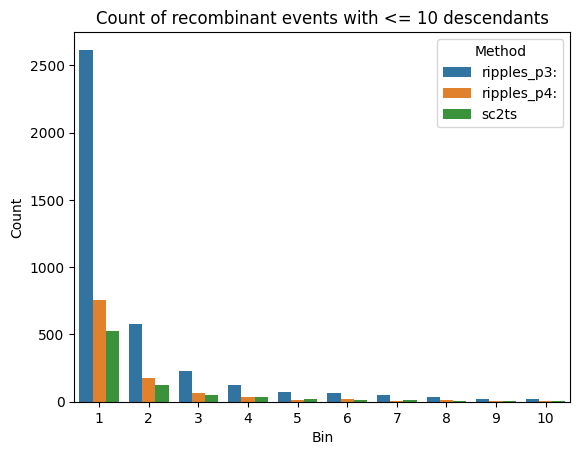

In [9]:
ax = sns.barplot(data=df_lf[df_lf["bins"] < 11], x="Bin", y="Count", hue="Method")
ax.set_title("Count of recombinant events with <= 10 descendants");

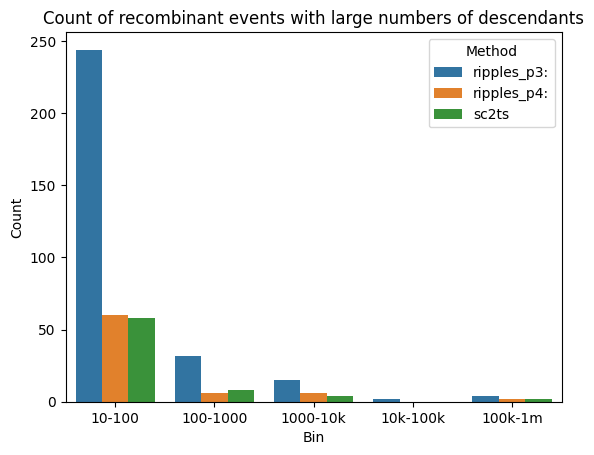

In [10]:
ax = sns.barplot(data=df_lf[df_lf["bins"] >= 11], x="Bin", y="Count", hue="Method");
ax.set_title("Count of recombinant events with large numbers of descendants");

## Singletons

We focus on the singletons as these are unequivocally comparable. Other nodes depend on the inferred topolology. We focus on p=4 as this is comparable with sc2ts.

There are 757 in total, and 705 of these in which sc2ts is also a singleton. Of these, 323 are directly associated with a recombination event, and 254 pass 3SEQ validation, and 228 have all three of the sample and putatative parents as samples. Of these, 216 had at least one parent in which the sampling date was more recent than the child sequence, and on average, the most recent parent comes 63 days after the child. Thus, these trios were not possible for sc2ts, in which enforces strict time ordering on sample dates. 

In [119]:
323 / 757

0.42668428005284015

In [69]:
dfp4_single = dfp4[dfp4["usher_num_descendants"] == 1]
dfp4_single

,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,usher_num_descendants,x_lineage_involved,passes_3seq
usher_node,,,,,,,,
SRR21610934,{'BA.5.2': 1},1360126,1,1189192,6,1,False,True
node_600484,{'XBR': 1},1420165,1,1420166,1,1,True,False
SRR20186719,{'AY.119.2': 1},862839,2,295320,7,1,False,True
ERR6758858,{'AY.4': 1},478619,1,478620,1,1,False,True
ERR7310305,{'AY.4': 1},707305,1,707306,1,1,False,False
...,...,...,...,...,...,...,...,...
ERR6702609,{'AY.4': 1},440103,1,295320,6,1,False,True
ERR7395506,{'AY.46.5': 1},714838,1,-1,2147483648,1,False,True
ERR7307967,{'AY.4.2.1': 1},633936,4,633937,1,1,False,True


In [70]:
df = dfp4_single[dfp4_single["sc2ts_num_descendants"] == 1]
df.shape[0]

705

In [71]:
np.sum(df["sc2ts_closest_recombinant_path_len"] == 1)

np.int64(323)

In [72]:
df = df[df["sc2ts_closest_recombinant_path_len"] > 1].copy()

In [74]:
df["passes_3seq"].value_counts()

passes_3seq
True     254
False    128
Name: count, dtype: int64

In [75]:
df = df[df["passes_3seq"]]
df = df.join(df3sp4)
df.shape[0]

254

In [77]:
# Filter out events where child or either parent is not a sample

df = df[~(df["child"].str.contains("node")
          | df["left_parent"].str.contains("node")
          | df["right_parent"].str.contains("node"))]
df.shape[0]

228

In [79]:
df_sample_date = ds.metadata.as_dataframe(["Date_tree"])
# Filter out imprecise dates 
df_sample_date = df_sample_date[df_sample_date["Date_tree"].str.len() == 10]
sample_date = pd.to_datetime(df_sample_date["Date_tree"], format='ISO8601')

In [93]:
df["child_date"] = sample_date[df["child"]]
df["left_parent_date"] = {k: sample_date[row["left_parent"]] for k, row in df.iterrows()} 
df["right_parent_date"] = {k: sample_date[row["right_parent"]] for k, row in df.iterrows()} 
df["min_parent_date"] = {k: min(sample_date[row["right_parent"]], 
                                sample_date[row["left_parent"]]) for k, row in df.iterrows()} 

In [90]:
np.sum((df["child_date"] < df["left_parent_date"]) & (df["child_date"] < df["right_parent_date"]))

np.int64(12)

In [118]:
216 / 228

0.9473684210526315

In [114]:
df = df[df["child_date"] >= df["min_parent_date"]]
df.shape

(216, 28)

<Axes: >

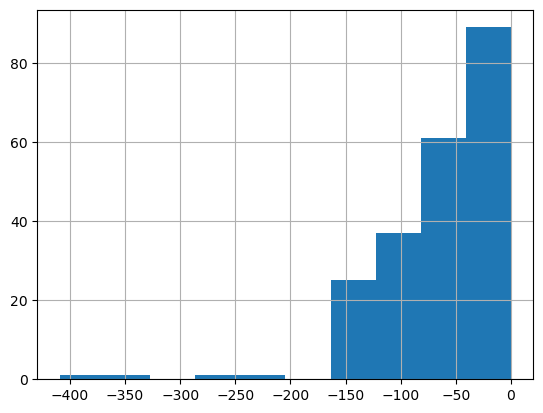

In [115]:
(df["min_parent_date"] - df["child_date"]).dt.days.hist()

In [117]:
(df["min_parent_date"] - df["child_date"]).mean()

Timedelta('-63 days +02:20:00')

## X lineages

In [11]:
dfp3_x = dfp3[dfp3["x_lineage_involved"]].reset_index()
dfp3_x

,usher_node,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,usher_num_descendants,x_lineage_involved,in_p4
0,node_600484,{'XBR': 1},1420165,1,1420166,1,1,True,True
1,node_600480,"{'XBD': 30, 'XBR': 1, 'BA.2.75': 5}",1291791,7182,-1,2147483648,36,True,True
2,node_505768,{'XAC': 18},1219046,18,964555,4,18,True,True
3,node_633544,{'XY': 23},1192268,23,1187989,1,23,True,False
4,node_633571,{'XE': 1113},965352,1116,965353,1,1113,True,False
5,node_45191,{'XC': 5},414488,5,414488,0,5,True,True
6,node_633781,{'XL': 64},1034619,64,1034619,0,64,True,False
7,node_633519,"{'BA.2': 4, 'XM': 4}",1093549,8,1003220,1,8,True,True
8,SRR19708375,{'XAM': 1},1242107,1,1058654,7,1,True,False
9,node_409296,{'XA': 39},122444,39,122444,0,39,True,True


In [12]:
dfp3_x[dfp3_x["sc2ts_num_descendants"] != dfp3_x["usher_num_descendants"]]

,usher_node,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,usher_num_descendants,x_lineage_involved,in_p4
1,node_600480,"{'XBD': 30, 'XBR': 1, 'BA.2.75': 5}",1291791,7182,-1,2147483648,36,True,True
4,node_633571,{'XE': 1113},965352,1116,965353,1,1113,True,False
11,node_543116,{'XBB': 2361},1396207,6453,1396207,0,6452,True,False
13,node_505720,"{'BA.1.15': 1, 'XS': 17, 'BA.1': 1, 'BA.1.1': 1}",220185,1061795,-1,2147483648,20,True,False
14,node_516786,"{'XAJ': 18, 'BA.4': 1}",974731,45209,-1,2147483648,19,True,True
17,node_633486,"{'XE': 1113, 'XH': 2, 'XJ': 68, 'XY': 23, 'BA....",791357,341822,-1,2147483648,1321,True,False
20,node_600488,"{'XBD': 30, 'BA.2.75': 5}",1291791,7182,-1,2147483648,35,True,True


In [13]:
dfp3_x["in_p4"].value_counts()

in_p4
True     12
False    10
Name: count, dtype: int64

## Mapping X events to nodes in sc2ts ARG

In [14]:
pango_x_events = pd.read_csv("../data/pango_x_events.csv").set_index("root")
mapping = pango_x_events["root_pango"].to_dict()
import collections
collections.Counter(mapping.values()).most_common(5)


[('XM', 4), ('XAC', 4), ('XAD', 2), ('XA', 1), ('XJ', 1)]

The mapping is messy here because of 3 X lineages which we need to disambiguate. There's only two XAD samples which are both under Xx. They don't show up in the RIPPLES results, so let's not worry about them


### XAC
XAC is really one event, it's just because of mislabelling in by Pangolin. The MRCA of the XACs really is the same node in both

In [15]:
ts = tszip.load("../data/sc2ts_viridian_v1.2.trees.tsz")
dfn = sc2ts.node_data(ts, inheritance_stats=False)
df_sample = dfn[dfn["is_sample"]]

In [16]:
df_xac = df_sample[df_sample["pango"] == "XAC"]
xac_mrca = ts.first().mrca(*df_xac["node_id"].values)
xac_mrca

1219046

In [17]:
dfp4[dfp4["pango_counts"] == {'XAC': 18}]

,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,usher_num_descendants,x_lineage_involved
usher_node,,,,,,,
node_505768,{'XAC': 18},1219046,18,964555,4,18,True


In [18]:
{k: v for k, v in mapping.items() if v == "XAC"}

{1223586: 'XAC', 2744536: 'XAC', 1214068: 'XAC', 1235679: 'XAC'}

In [19]:
mapping = {k: v for k, v in mapping.items() if v != "XAC"}
mapping[xac_mrca] = "XAC"

### XM

XM is messy because we have 4 different events in the ARG. We call the major one XM, and then the minor ones XM1, 2, arbitrarily.

In [20]:
pango_x_events[pango_x_events["pango"] == "XM"]

,root_pango,root_mutations,root_type,pango_samples,non_pango_samples,closest_recombinant,closest_recombinant_path_len,closest_recombinant_time,closest_recombinant_descendants,pango
root,,,,,,,,,,
938900,XM,2,R,1,{},938900,0.0,0.0,{'XM': 1},XM
1003220,XM,0,R,26,"{'BA.2': 16, 'XAL': 3}",1003220,0.0,0.0,"{'XM': 26, 'BA.2': 16, 'XAL': 3}",XM
1158127,XM,1,R,1,{},1158127,0.0,0.0,{'XM': 1},XM
1158182,XM,6,R,1,{},1158182,0.0,0.0,{'XM': 1},XM


## XBM

XBM is a type II event, with the recomb slightly ancestral to the clade 


In [21]:
mapping = {k: v for k, v in mapping.items() if v != "XBM"}
node = pango_x_events[pango_x_events["root_pango"] == "XBM"]["closest_recombinant"].values[0]
mapping[int(node)] = "XBM"

In [22]:
j = 1
for root, row in pango_x_events[pango_x_events["pango"] == "XM"].iterrows():
    if row["pango_samples"] == 1:
        mapping[root] = f"XM{j}"
        j += 1


In [23]:
collections.Counter(mapping.values()).most_common(5)

[('XAD', 2), ('XA', 1), ('XJ', 1), ('XB', 1), ('XAP', 1)]

In [24]:
# Remove the novel XBB.1 also
mapping = {k: v for k, v in mapping.items() if v not in ["XAD", "XBB.1"]}

In [25]:
node = pango_x_events[pango_x_events["root_pango"] == "XH"]["closest_recombinant"].values[0]
mapping[int(node)] = "XE/XH"

node = pango_x_events[pango_x_events["root_pango"] == "XZ"]["closest_recombinant"].values[0]
mapping[int(node)] = "Xx"



In [26]:
mapping

{122444: 'XA',
 966904: 'XJ',
 223239: 'XB',
 1216836: 'XAP',
 1301399: 'XAN',
 1187989: 'XY',
 1420385: 'XBF',
 1148222: 'XR',
 1058654: 'XQ',
 1163537: 'XZ',
 1243765: 'XU',
 1240312: 'XAM',
 1183815: 'XAA',
 1363926: 'XBE',
 1098084: 'XH',
 1420166: 'XBR',
 1000242: 'XS',
 1159411: 'XW',
 1264107: 'XAL',
 1061700: 'XN',
 414488: 'XC',
 1248341: 'XAG',
 1276376: 'XAJ',
 938900: 'XM1',
 1003220: 'XM',
 1158127: 'XM2',
 1158182: 'XM3',
 1425824: 'XBK',
 1118099: 'XAE',
 1396207: 'XBB',
 946761: 'XF',
 1231548: 'XAU',
 1092789: 'XP',
 1422955: 'XBQ',
 1285706: 'XAZ',
 1265115: 'XAS',
 1291970: 'XBG',
 1269391: 'XAV',
 1083412: 'XG',
 1034619: 'XL',
 1314603: 'XAF',
 1379419: 'XBH',
 965352: 'XE',
 1378208: 'XBD',
 1219046: 'XAC',
 1348822: 'XBM',
 965353: 'XE/XH',
 964555: 'Xx'}

In [27]:
assert len(set(mapping.values())) == len(mapping)
df_sc2ts["event_label"] = {k: mapping.get(k, "novel") for k in df_sc2ts.index}
df_sc2ts_x_events = df_sc2ts[df_sc2ts["event_label"] != "novel"]
df_sc2ts_x_events

,sample_id,num_descendant_samples,num_samples,distinct_sample_pango,interval_left,interval_right,num_mutations,Viridian_amplicon_scheme,Artic_primer_version,date_added,...,parent_mrca_date,is_rebar_recombinant,parent_pangonet_distance,net_min_supporting_loci_lft,net_min_supporting_loci_rgt,net_min_supporting_loci_lft_rgt_ge_4,k1000_muts,event_label,ripples_p4,ripples_p3
recombinant,,,,,,,,,,,,,,,,,,,,,
1159411,ERR9444530,32,1,1,2833,4321,1,COVID-ARTIC-V4.1,4.1alt,2022-03-20,...,2020-06-26,True,4,5,48,True,5,XW,False,True
1058654,ERR8691075,154,1,1,4322,5386,0,COVID-ARTIC-V4.1,4.1alt,2022-02-12,...,2020-06-26,True,5,8,43,True,7,XQ,False,False
946761,ERR8076129,16,1,1,5387,6402,1,COVID-ARTIC-V4.1,4.1alt,2022-01-13,...,2020-01-28,True,6,6,74,True,6,XF,False,False
1083412,ERR9089519,3,1,1,5925,6513,3,COVID-ARTIC-V4.1,4.1alt,2022-02-19,...,2020-06-26,True,3,9,38,True,7,XG,False,False
1034619,ERR8627711,64,3,1,5925,8393,1,COVID-ARTIC-V4.1,4.1alt,2022-02-06,...,2020-06-26,True,5,10,40,True,9,XL,False,True
1420385,ERR10708634,185,11,3,5184,9866,4,COVID-ARTIC-V4.1,4.1alt,2022-12-20,...,2021-11-11,True,10,8,29,True,9,XBF,False,False
1000242,SRR19817338,17,1,1,9054,10449,2,COVID-AMPLISEQ-V1,.,2022-01-28,...,2020-01-28,True,7,16,76,True,13,XS,True,True
965353,ERR8153803,1156,1,1,10448,11283,1,COVID-ARTIC-V4.1,4.1alt,2022-01-19,...,2020-06-26,True,4,15,33,True,7,XE/XH,False,False
1187989,SRR20520593,23,1,1,11538,12880,3,COVID-ARTIC-V4.1,.,2022-04-01,...,2020-06-26,True,3,22,31,True,8,XY,False,True


## Matching up events between sc2ts and Usher+ripples

In [28]:
def label_events(df):
    event_label = {}
    sc2ts_event_label = {}
    for key, row in df.iterrows():
        d = row["pango_counts"]
        event_label[key] = "messy"
        if len(d) == 1:
            event_label[key] = list(d.keys())[0]
        sc2ts_event_label[key] = mapping.get(row["sc2ts_closest_recombinant"], "NA")
        if "XB" in d:
            sc2ts_event_label[key] = "XB"
    df["event_label"] = event_label
    df["sc2ts_event_label"] = sc2ts_event_label
    return df
            


dfp3_x = label_events(dfp3_x).copy()

In [29]:
# Manually correct the recombinant path lens for a few 
events = ["XBR", "XM3", "XY", "XW"]

dfp3_x.loc[dfp3_x["sc2ts_event_label"].isin(events), "sc2ts_closest_recombinant_path_len"] = 0

In [30]:
sc2ts_event_type = {}
for k, row in dfp3_x.iterrows():
    path_len = row["sc2ts_closest_recombinant_path_len"]
    if path_len == 0:
        e = "I"
    elif path_len < 10**6:
        e = "II"
    else:
        e = "NA"
    if "XB" in row["pango_counts"]:
        e = "IV"
    sc2ts_event_type[k] = e


dfp3_x["sc2ts_event_type"] = sc2ts_event_type

In [31]:
t = dfp3_x.sort_values(["sc2ts_event_type", "usher_num_descendants"])
t["clade_diff"] = t["sc2ts_num_descendants"] - t["usher_num_descendants"] 

t = t[["sc2ts_event_label", "in_p4", "usher_num_descendants", "sc2ts_event_type", "clade_diff", "pango_counts"]]
t

,sc2ts_event_label,in_p4,usher_num_descendants,sc2ts_event_type,clade_diff,pango_counts
0,XBR,True,1,I,0,{'XBR': 1}
21,XM3,True,1,I,0,{'XM': 1}
5,XC,True,5,I,0,{'XC': 5}
18,XBM,True,12,I,0,"{'XBM': 10, 'BF.3': 2}"
19,XS,True,17,I,0,{'XS': 17}
3,XY,False,23,I,0,{'XY': 23}
10,XW,False,32,I,0,{'XW': 32}
9,XA,True,39,I,0,{'XA': 39}
6,XL,False,64,I,0,{'XL': 64}
11,XBB,False,6452,I,1,{'XBB': 2361}


In [32]:
col_name_map = {
    "sc2ts_event_label": "pango",
    "in_p4": "in p4",
    "usher_num_descendants": "UShER desc", 
    "sc2ts_event_type": "sc2ts class",
    "clade_diff": "clade diff",
    "pango_counts": "descendants",
  
    #"closest_recombinant_descendants": "by pango",
}
s = t[list(col_name_map.keys())].to_latex(
        escape=False, index=False, header=list(col_name_map.values()),
        float_format="%.0f")
s = s.replace("'", "").replace(": ", ":") 

print(s)

\begin{tabular}{lrrlrl}
\toprule
pango & in p4 & UShER desc & sc2ts class & clade diff & descendants \\
\midrule
XBR & True & 1 & I & 0 & {XBR:1} \\
XM3 & True & 1 & I & 0 & {XM:1} \\
XC & True & 5 & I & 0 & {XC:5} \\
XBM & True & 12 & I & 0 & {XBM:10, BF.3:2} \\
XS & True & 17 & I & 0 & {XS:17} \\
XY & False & 23 & I & 0 & {XY:23} \\
XW & False & 32 & I & 0 & {XW:32} \\
XA & True & 39 & I & 0 & {XA:39} \\
XL & False & 64 & I & 0 & {XL:64} \\
XBB & False & 6452 & I & 1 & {XBB:2361} \\
XQ & False & 1 & II & 0 & {XAM:1} \\
XM & True & 8 & II & 0 & {BA.2:4, XM:4} \\
Xx & False & 9 & II & 0 & {XAE:9} \\
Xx & True & 18 & II & 0 & {XAC:18} \\
XQ & False & 21 & II & 0 & {XAM:21} \\
XE/XH & False & 1113 & II & 3 & {XE:1113} \\
XB & True & 411 & IV & 0 & {B.1:219, XB:192} \\
NA & True & 19 & NA & 45190 & {XAJ:18, BA.4:1} \\
NA & False & 20 & NA & 1061775 & {BA.1.15:1, XS:17, BA.1:1, BA.1.1:1} \\
NA & True & 35 & NA & 7147 & {XBD:30, BA.2.75:5} \\
NA & True & 36 & NA & 7146 & {XBD:30, XBR:1, BA.

In [33]:
dfp3_x[dfp3_x.event_label != "messy"]

,usher_node,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,usher_num_descendants,x_lineage_involved,in_p4,event_label,sc2ts_event_label,sc2ts_event_type
0,node_600484,{'XBR': 1},1420165,1,1420166,0,1,True,True,XBR,XBR,I
2,node_505768,{'XAC': 18},1219046,18,964555,4,18,True,True,XAC,Xx,II
3,node_633544,{'XY': 23},1192268,23,1187989,0,23,True,False,XY,XY,I
4,node_633571,{'XE': 1113},965352,1116,965353,1,1113,True,False,XE,XE/XH,II
5,node_45191,{'XC': 5},414488,5,414488,0,5,True,True,XC,XC,I
6,node_633781,{'XL': 64},1034619,64,1034619,0,64,True,False,XL,XL,I
8,SRR19708375,{'XAM': 1},1242107,1,1058654,7,1,True,False,XAM,XQ,II
9,node_409296,{'XA': 39},122444,39,122444,0,39,True,True,XA,XA,I
10,node_633846,{'XW': 32},1159410,32,1159411,0,32,True,False,XW,XW,I
11,node_543116,{'XBB': 2361},1396207,6453,1396207,0,6452,True,False,XBB,XBB,I


In [34]:
dfp3_x[dfp3_x.event_label == "messy"]

,usher_node,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,usher_num_descendants,x_lineage_involved,in_p4,event_label,sc2ts_event_label,sc2ts_event_type
1,node_600480,"{'XBD': 30, 'XBR': 1, 'BA.2.75': 5}",1291791,7182,-1,2147483648,36,True,True,messy,NA,NA
7,node_633519,"{'BA.2': 4, 'XM': 4}",1093549,8,1003220,1,8,True,True,messy,XM,II
13,node_505720,"{'BA.1.15': 1, 'XS': 17, 'BA.1': 1, 'BA.1.1': 1}",220185,1061795,-1,2147483648,20,True,False,messy,NA,NA
14,node_516786,"{'XAJ': 18, 'BA.4': 1}",974731,45209,-1,2147483648,19,True,True,messy,NA,NA
15,node_6681,"{'B.1': 219, 'XB': 192}",223240,411,-1,2147483648,411,True,True,messy,XB,IV
17,node_633486,"{'XE': 1113, 'XH': 2, 'XJ': 68, 'XY': 23, 'BA....",791357,341822,-1,2147483648,1321,True,False,messy,NA,NA
18,node_600527,"{'XBM': 10, 'BF.3': 2}",1348822,12,1348822,0,12,True,True,messy,XBM,I
20,node_600488,"{'XBD': 30, 'BA.2.75': 5}",1291791,7182,-1,2147483648,35,True,True,messy,NA,NA


In [35]:
dfp3_x[dfp3_x.event_label != "messy"].join(df_sc2ts, on="sc2ts_closest_recombinant", rsuffix="_sc2ts")[["event_label", "event_label_sc2ts"]]

,event_label,event_label_sc2ts
0,XBR,XBR
2,XAC,Xx
3,XY,XY
4,XE,XE/XH
5,XC,XC
6,XL,XL
8,XAM,XQ
9,XA,XA
10,XW,XW
11,XBB,XBB


In [36]:
cols = ["event_label", "event_label_sc2ts", "usher_num_descendants", "sc2ts_num_descendants"]
t = dfp3_x[dfp3_x.event_label != "messy"].join(df_sc2ts, on="sc2ts_closest_recombinant", rsuffix="_sc2ts")
tmp = t[t["in_p4"]][cols]
print(tmp.to_latex(index=False))

\begin{tabular}{llrr}
\toprule
event_label & event_label_sc2ts & usher_num_descendants & sc2ts_num_descendants \\
\midrule
XBR & XBR & 1 & 1 \\
XAC & Xx & 18 & 18 \\
XC & XC & 5 & 5 \\
XA & XA & 39 & 39 \\
XS & XS & 17 & 17 \\
XM & XM3 & 1 & 1 \\
\bottomrule
\end{tabular}



In [37]:
tmp = t[~t["in_p4"]][cols]
print(tmp.to_latex(index=False))

\begin{tabular}{llrr}
\toprule
event_label & event_label_sc2ts & usher_num_descendants & sc2ts_num_descendants \\
\midrule
XY & XY & 23 & 23 \\
XE & XE/XH & 1113 & 1116 \\
XL & XL & 64 & 64 \\
XAM & XQ & 1 & 1 \\
XW & XW & 32 & 32 \\
XBB & XBB & 6452 & 6453 \\
XAM & XQ & 21 & 21 \\
XAE & Xx & 9 & 9 \\
\bottomrule
\end{tabular}



# Singletons



In [38]:
df_sc2ts_single = df_sc2ts[df_sc2ts["num_descendant_samples"] == 1]
df_sc2ts_single.shape

(525, 50)

In [39]:
dfp3_single = dfp3[dfp3["usher_num_descendants"] == 1]
dfp3_single.shape

(2616, 8)

In [40]:
dfp3_single.in_p4.value_counts()

in_p4
False    1862
True      754
Name: count, dtype: int64

In [41]:
df_join = dfp3_single.join(df_sc2ts_single, "sc2ts_closest_recombinant")
df_join = df_join[df_join["sc2ts_closest_recombinant_path_len"] == 1]
df_join

,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,usher_num_descendants,x_lineage_involved,in_p4,sample_id,num_descendant_samples,...,parent_mrca_date,is_rebar_recombinant,parent_pangonet_distance,net_min_supporting_loci_lft,net_min_supporting_loci_rgt,net_min_supporting_loci_lft_rgt_ge_4,k1000_muts,event_label,ripples_p4,ripples_p3
usher_node,,,,,,,,,,,,,,,,,,,,,
node_600484,{'XBR': 1},1420165,1,1420166,1,1,True,True,ERR10778074,1.0,...,2021-11-11,True,13.0,25.0,26.0,True,24.0,XBR,True,True
ERR6758858,{'AY.4': 1},478619,1,478620,1,1,False,True,ERR6758858,1.0,...,2020-12-28,False,2.0,11.0,-3.0,False,7.0,novel,True,True
ERR7310305,{'AY.4': 1},707305,1,707306,1,1,False,True,ERR7310305,1.0,...,2020-12-28,False,0.0,4.0,-1.0,False,6.0,novel,True,True
SRR20258232,{'AY.39.1': 1},652406,1,652407,1,1,False,True,SRR20258232,1.0,...,2020-12-28,False,1.0,14.0,-1.0,False,6.0,novel,True,True
node_181897,{'AY.100': 1},894830,1,894831,1,1,False,True,SRR20917400,1.0,...,2020-12-28,False,0.0,5.0,-1.0,False,8.0,novel,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
node_180710,{'AY.4': 1},586963,1,586964,1,1,False,True,ERR7046820,1.0,...,2020-12-28,False,2.0,15.0,2.0,False,7.0,novel,True,True
ERR10306440,{'BA.4': 1},1376014,1,1376015,1,1,False,False,ERR10306440,1.0,...,2022-03-16,False,1.0,2.0,8.0,False,9.0,novel,False,True
node_507989,{'BA.2.12.1': 1},1251637,1,1251638,1,1,False,True,SRR19672131,1.0,...,2021-11-11,False,3.0,9.0,15.0,True,9.0,novel,True,True


In [42]:
df_join.in_p4.value_counts()

in_p4
True     327
False     90
Name: count, dtype: int64

In [135]:
total_sc2ts = df_sc2ts_single.shape[0]
total_p3 = dfp3_single.shape[0]
total_p4 = np.sum(dfp3_single["in_p4"])
inter_p3 = df_join.shape[0]
inter_p4 = np.sum(df_join["in_p4"])

print("Singletons")
print("Total sc2ts =", total_sc2ts)
print("Total RIPPLES p3 =", total_p3)
print("Intersection  p3 = ", inter_p3)
print("Total RIPPLES p4 =", total_p4)
print("Intersection  p4 = ", inter_p4)

NameError: name 'df_sc2ts_single' is not defined

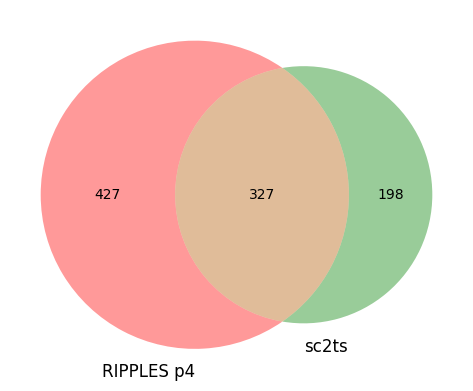

In [44]:
# accept as their only required argument a 3-element tuple (Ab, aB, AB)
matplotlib_venn.venn2([total_p4 - inter_p4, total_sc2ts - inter_p4, inter_p4], [f"RIPPLES p4", "sc2ts"]);

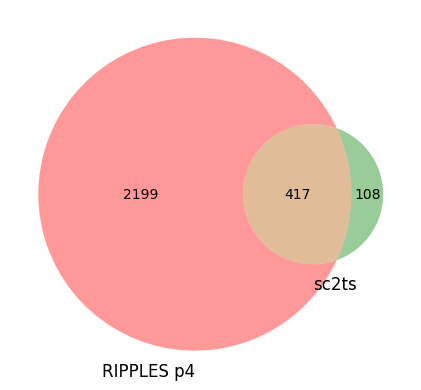

In [45]:
matplotlib_venn.venn2([total_p3 - inter_p3, total_sc2ts - inter_p3,  inter_p3], [f"RIPPLES p4", "sc2ts"]);




### Overall

Clade agreement = 3755 91.3%
Non recombinant = 68.1%
Close to recombinant = 16.1%
Passing filter =  603
Total ripples = 4111
Total sc2ts =  855


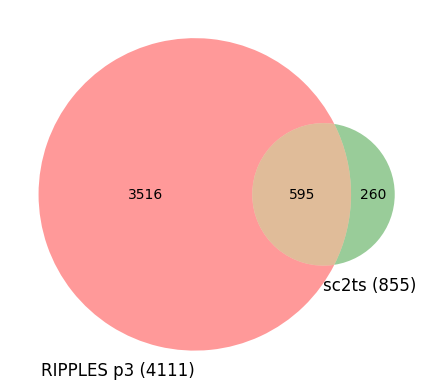

In [136]:
def get_sc2ts_recombinants(df, clade_agreement_threshold=1, closeness=1):
    diffs = df["sc2ts_num_descendants"] - df["usher_num_descendants"]
    clade_agreement = diffs <= clade_agreement_threshold
    print(f"Clade agreement = {clade_agreement.sum()} {clade_agreement.sum() / df.shape[0]:.1%}")
    df = df[clade_agreement]
    close_to_recombinant = df["sc2ts_closest_recombinant_path_len"] <= closeness
    not_recombinant = df["sc2ts_closest_recombinant"] == -1
    print(f"Non recombinant = {not_recombinant.sum() / df.shape[0]:.1%}")
    print(f"Close to recombinant = {close_to_recombinant.sum() / df.shape[0]:.1%}")
    df = df[close_to_recombinant]
    print("Passing filter = ", df.shape[0])
    #print(df["sc2ts_closest_recombinant"].value_counts())
    sc2ts_recombs = df["sc2ts_closest_recombinant"].unique()
    return sc2ts_recombs
    
def draw_venn(df, label, sc2ts_recombs, ax=None):
    total_ripples = df.shape[0]
    total_sc2ts = 855
    shared = sc2ts_recombs.shape[0]
    print("Total ripples =", total_ripples)
    print("Total sc2ts = ", total_sc2ts)
    # Note: it would be nice to fix the size of the sc2ts circle here an let the 
    # ripples one get bigger, but it's not obvious how to do it.
    layout_algorithm = matplotlib_venn.layout.venn2.DefaultLayoutAlgorithm()
    matplotlib_venn.venn2(
        [total_ripples - shared, total_sc2ts - shared, shared], 
        [f"RIPPLES {label} ({total_ripples})", f"sc2ts ({total_sc2ts})"], 
        layout_algorithm=layout_algorithm, ax=ax);

sc2ts_recombs_p3 = get_sc2ts_recombinants(dfp3, clade_agreement_threshold=1, closeness=1)
draw_venn(dfp3, "p3", sc2ts_recombs_p3)
plt.savefig("../figures/ripples_p3_sc2ts_events.pdf")

Clade agreement = 1052 89.6%
Non recombinant = 41.2%
Close to recombinant = 44.5%
Passing filter =  468
Total ripples = 1174
Total sc2ts =  855


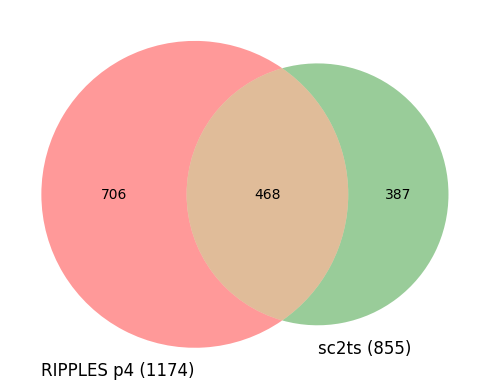

In [138]:
sc2ts_recombs_p4 = get_sc2ts_recombinants(dfp4) #dfp3[dfp3["in_p4"]])
draw_venn(dfp4, "p4", sc2ts_recombs_p4)
plt.savefig("../figures/ripples_p4_sc2ts_events.pdf")

### Intersection analysis for paper

This is the analysis I used for the paper.

In [139]:
468 / 1174

0.3986371379897785

In [140]:
468 / 855

0.5473684210526316

In [170]:
595/855

0.695906432748538

In [141]:
p4recombinants = get_sc2ts_recombinants(dfp4)

Clade agreement = 1052 89.6%
Non recombinant = 41.2%
Close to recombinant = 44.5%
Passing filter =  468


In [146]:
dfp4_not_sc2ts = dfp4[~dfp4.sc2ts_closest_recombinant.isin(p4recombinants)]
dfp4_not_sc2ts

,parent1,parent2,recombinant_date,parent1_date,parent2_date,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,sc2ts_num_mutations,x_lineage_involved,usher_num_descendants,max_parent_date,min_parent_branch_length,passes_3seq
recombinant,,,,,,,,,,,,,,,,
SRR21610934,SRR21868903,SRR21671375,2022-09-04,2022-09-21,2022-09-06,{'BA.5.2': 1},1360126,1,1189192,6,4,False,1,2022-09-21,-17,True
SRR20186719,SRR20940284,SRR15391719,2021-12-06,2021-12-07,2021-07-21,{'AY.119.2': 1},862839,2,295320,7,5,False,1,2021-12-07,-1,True
node_181040,ERR6203132,ERR6470123,2021-08-23,2021-06-20,2021-08-01,{'AY.4': 2},378676,282,-1,2147483648,2,False,2,2021-08-01,22,True
node_180844,ERR7303279,ERR7147134,2021-10-12,2021-10-11,2021-10-06,{'AY.4.2': 6},606246,24,-1,2147483648,4,False,6,2021-10-11,1,True
ERR7239088,ERR7274565,ERR8248180,2021-10-08,2021-10-26,2021-12-09,{'AY.4': 1},615438,1,-1,2147483648,4,False,1,2021-12-09,-62,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
node_180898,SRR16637012,ERR6203132,2021-10-06,2021-10-05,2021-06-20,{'AY.4': 12},596009,82,-1,2147483648,1,False,12,2021-10-05,1,True
ERR7395506,ERR6735585,ERR6148731,2021-11-03,2021-09-06,2021-06-21,{'AY.46.5': 1},714838,1,-1,2147483648,5,False,1,2021-09-06,58,True
ERR7307967,ERR7307485,ERR7350337,2021-10-13,2021-10-23,2021-11-02,{'AY.4.2.1': 1},633936,4,633937,1,0,False,1,2021-11-02,-20,True


In [149]:
np.sum(dfp4_not_sc2ts["min_parent_branch_length"] <= 0)

np.int64(408)

In [156]:
dfp4_not_sc2ts_not_tt = dfp4_not_sc2ts[dfp4_not_sc2ts["min_parent_branch_length"] > 0]
stragglers = dfp4_not_sc2ts_not_tt[
    ((dfp4_not_sc2ts_not_tt["sc2ts_num_descendants"] - dfp4_not_sc2ts_not_tt["usher_num_descendants"]).abs() < 2) &
    (dfp4_not_sc2ts_not_tt["sc2ts_num_mutations"] > 4)]
stragglers

,parent1,parent2,recombinant_date,parent1_date,parent2_date,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,sc2ts_num_mutations,x_lineage_involved,usher_num_descendants,max_parent_date,min_parent_branch_length,passes_3seq
recombinant,,,,,,,,,,,,,,,,
SRR15628733,SRR15534657,node_180647,2021-08-05,2021-08-02,2021-07-13,{'AY.110': 1},395118,1,-1,2147483648,7,False,1,2021-08-02,3,False
SRR21173296,SRR16900296,ERR6634797,2021-10-27,2021-10-19,2021-08-26,{'AY.26': 1},685800,1,-1,2147483648,8,False,1,2021-10-19,8,True
ERR6629362,ERR6387573,ERR6203132,2021-08-08,2021-07-22,2021-06-20,{'AY.4': 1},402648,1,295320,4,5,False,1,2021-07-22,17,True
SRR20953902,SRR21175830,ERR6440908,2021-11-09,2021-10-26,2021-07-26,{'AY.119': 1},743713,1,-1,2147483648,7,False,1,2021-10-26,14,True
ERR7240684,ERR6922762,ERR6568434,2021-10-07,2021-09-27,2021-08-08,{'AY.4': 1},611140,1,-1,2147483648,6,False,1,2021-09-27,10,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
node_549711,SRR20136361,ERR10001748,2022-08-07,2022-06-16,2022-07-06,{'BA.5.1': 3},1334138,3,1189192,4,8,False,3,2022-07-06,32,False
node_628857,ERR8065350,ERR4699437,2022-02-23,2022-01-11,2020-10-05,{'BA.2.3': 1},1095086,1,-1,2147483648,6,False,1,2022-01-11,43,False
SRR19684011,SRR19835135,SRR19689862,2022-02-14,2022-02-03,2022-02-11,{'BA.1.1': 1},1067840,1,-1,2147483648,7,False,1,2022-02-11,3,False


In [157]:
remap_sites = pd.read_csv("../arg_postprocessing/sc2ts_v1_2023-02-21_pr_pp_sites_to_remap.csv")
remap_sites

,position,reason
0,203,pango
1,222,pango
2,335,pango
3,337,pango
4,683,pango
...,...,...
158,29762,pango
159,29769,pango
160,29774,pango
161,29779,pango


In [159]:
df_mutation = sc2ts.mutation_data(ts)

2025-10-15 22:00:59,165 INFO:Computing inheritance counts


In [162]:
straggler_mutations = df_mutation[df_mutation["node"].isin(stragglers["sc2ts_mrca"])]
straggler_mutations

,mutation_id,position,parent,node,inherited_state,derived_state,date,num_descendants,num_inheritors
2778,2778,84,-1,913470,C,T,2021-11-10,1,1
7766,7766,147,-1,610888,C,T,2021-08-14,1,1
13252,13252,192,-1,698148,G,T,2021-09-24,1,1
16855,16855,203,-1,861794,C,T,2021-10-09,1,1
18691,18691,203,-1,1355674,C,T,2022-06-18,2,2
...,...,...,...,...,...,...,...,...,...
2235853,2235853,29774,-1,644255,C,T,2021-08-22,1,1
2250688,2250688,29779,-1,448341,G,T,2021-07-23,1,1
2254867,2254867,29779,-1,639016,G,T,2021-10-07,1,1
2258294,2258294,29779,-1,790418,G,T,2021-11-10,1,1


In [169]:
np.sum(straggler_mutations["position"].isin(remap_sites["position"]))

np.int64(452)

## Add Ripples p3/p4 classification to sc2ts dataframe

In [48]:
df_sc2ts["is_ripples_p4_recombinant"] = {k: k in sc2ts_recombs_p4 for k in df_sc2ts.index}
df_sc2ts["is_ripples_p3_recombinant"] = {k: k in sc2ts_recombs_p3 for k in df_sc2ts.index}
df_sc2ts

,sample_id,num_descendant_samples,num_samples,distinct_sample_pango,interval_left,interval_right,num_mutations,Viridian_amplicon_scheme,Artic_primer_version,date_added,...,parent_pangonet_distance,net_min_supporting_loci_lft,net_min_supporting_loci_rgt,net_min_supporting_loci_lft_rgt_ge_4,k1000_muts,event_label,ripples_p4,ripples_p3,is_ripples_p4_recombinant,is_ripples_p3_recombinant
recombinant,,,,,,,,,,,,,,,,,,,,,
1280342,ERR9939974,1,1,1,695,958,1,COVID-ARTIC-V4.1,.,2022-06-27,...,5,2,16,False,8,novel,False,False,False,False
663484,SRR20259474,1,1,1,510,1222,1,COVID-AMPLISEQ-V1,.,2021-10-21,...,2,2,16,False,5,novel,False,True,False,True
1356368,ERR10219711,2,1,1,695,1453,1,COVID-ARTIC-V4.1,.,2022-08-30,...,4,1,16,False,5,novel,False,False,False,False
1253364,ERR9848224,855,1,1,695,1627,1,COVID-ARTIC-V4.1,.,2022-05-30,...,4,1,54,False,7,novel,False,False,False,False
1279026,ERR9940192,662,1,1,695,1627,0,COVID-ARTIC-V4.1,.,2022-06-26,...,3,2,8,False,6,novel,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375056,SRR21797337,1,1,1,26276,29729,1,COVID-ARTIC-V4.1,.,2022-09-19,...,2,22,2,False,5,novel,True,True,True,True
1373412,SRR21794908,2,1,1,28331,29729,2,COVID-ARTIC-V4.1,.,2022-09-17,...,5,25,2,False,7,novel,True,True,True,True
1418709,ERR10708209,37,12,1,28682,29729,8,COVID-ARTIC-V4.1,4.1alt,2022-12-17,...,8,23,2,False,10,novel,True,True,True,True


In [49]:
# TODO add this to the data frame automatically.

In [50]:
df_sc2ts.reset_index().to_csv("../data/recombinants.csv", index=False)

In [84]:
dfp4

,parent1,parent2,recombinant_date,parent1_date,parent2_date,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,sc2ts_num_mutations,x_lineage_involved,usher_num_descendants,max_parent_date,min_parent_branch_length
recombinant,,,,,,,,,,,,,,,
SRR21610934,SRR21868903,SRR21671375,2022-09-04,2022-09-21,2022-09-06,{'BA.5.2': 1},1360126,1,1189192,6,4,False,1,2022-09-21,-17
node_600484,ERR10214302,ERR10003171,2022-12-20,2022-09-08,2022-07-07,{'XBR': 1},1420165,1,1420166,1,0,True,1,2022-09-08,103
SRR20186719,SRR20940284,SRR15391719,2021-12-06,2021-12-07,2021-07-21,{'AY.119.2': 1},862839,2,295320,7,5,False,1,2021-12-07,-1
node_181040,ERR6203132,ERR6470123,2021-08-23,2021-06-20,2021-08-01,{'AY.4': 2},378676,282,-1,2147483648,2,False,2,2021-08-01,22
ERR6758858,ERR6387616,ERR6440908,2021-09-02,2021-07-22,2021-07-26,{'AY.4': 1},478619,1,478620,1,0,False,1,2021-07-26,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR7395506,ERR6735585,ERR6148731,2021-11-03,2021-09-06,2021-06-21,{'AY.46.5': 1},714838,1,-1,2147483648,5,False,1,2021-09-06,58
ERR7307967,ERR7307485,ERR7350337,2021-10-13,2021-10-23,2021-11-02,{'AY.4.2.1': 1},633936,4,633937,1,0,False,1,2021-11-02,-20
ERR6760263,ERR6539928,node_229210,2021-08-24,2021-07-30,2021-11-01,{'AY.4': 1},442463,1,-1,2147483648,7,False,1,2021-11-01,-69


In [ ]:
dfp4_close2

In [82]:
(dfp4["min_parent_branch_length"] <= 0).value_counts()

min_parent_branch_length
False    603
True     571
Name: count, dtype: int64

In [90]:
df_ttp = dfp4[dfp4["min_parent_branch_length"] < 0]
df_ttp

,parent1,parent2,recombinant_date,parent1_date,parent2_date,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,sc2ts_num_mutations,x_lineage_involved,usher_num_descendants,max_parent_date,min_parent_branch_length
recombinant,,,,,,,,,,,,,,,
SRR21610934,SRR21868903,SRR21671375,2022-09-04,2022-09-21,2022-09-06,{'BA.5.2': 1},1360126,1,1189192,6,4,False,1,2022-09-21,-17
SRR20186719,SRR20940284,SRR15391719,2021-12-06,2021-12-07,2021-07-21,{'AY.119.2': 1},862839,2,295320,7,5,False,1,2021-12-07,-1
ERR7239088,ERR7274565,ERR8248180,2021-10-08,2021-10-26,2021-12-09,{'AY.4': 1},615438,1,-1,2147483648,4,False,1,2021-12-09,-62
node_180673,SRR17136430,node_180672,2021-10-14,2021-10-28,2021-10-14,{'B.1.617.2': 3},638821,3,295320,4,7,False,3,2021-10-28,-14
node_181897,SRR17562766,node_181893,2021-12-15,2021-12-22,2021-08-07,{'AY.100': 1},894830,1,894831,1,0,False,1,2021-12-22,-7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
node_172849,SRR17374295,SRR16883831,2021-11-10,2021-12-13,2021-10-13,{'AY.100': 3},748738,3,748738,0,2,False,3,2021-12-13,-33
node_172951,SRR15224358,node_181706,2021-10-20,2021-07-11,2021-12-04,{'AY.100': 5},686369,7,-1,2147483648,4,False,5,2021-12-04,-45
node_507989,ERR9927058,SRR19779216,2022-05-28,2022-06-29,2022-05-31,{'BA.2.12.1': 1},1251637,1,1251638,1,0,False,1,2022-06-29,-32


In [91]:
np.sum(df_ttp["sc2ts_closest_recombinant_path_len"] <= 2)

np.int64(143)

In [34]:
pass3s = dfp4[dfp4["passes_3seq"]]
pass3s

,parent1,parent2,recombinant_date,parent1_date,parent2_date,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,sc2ts_num_mutations,x_lineage_involved,usher_num_descendants,min_parent_date,min_parent_branch_length,passes_3seq
recombinant,,,,,,,,,,,,,,,,
SRR21610934,SRR21868903,SRR21671375,2022-09-04,2022-09-21,2022-09-06,{'BA.5.2': 1},1360126,1,1189192,6,4,False,1,2022-09-06,-2,True
SRR20186719,SRR20940284,SRR15391719,2021-12-06,2021-12-07,2021-07-21,{'AY.119.2': 1},862839,2,295320,7,5,False,1,2021-07-21,138,True
node_181040,ERR6203132,ERR6470123,2021-08-23,2021-06-20,2021-08-01,{'AY.4': 2},378676,282,-1,2147483648,2,False,2,2021-06-20,64,True
ERR6758858,ERR6387616,ERR6440908,2021-09-02,2021-07-22,2021-07-26,{'AY.4': 1},478619,1,478620,1,0,False,1,2021-07-22,42,True
node_180844,ERR7303279,ERR7147134,2021-10-12,2021-10-11,2021-10-06,{'AY.4.2': 6},606246,24,-1,2147483648,4,False,6,2021-10-06,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR6702609,ERR6634454,ERR6203132,2021-08-23,2021-07-29,2021-06-20,{'AY.4': 1},440103,1,295320,6,0,False,1,2021-06-20,64,True
node_180898,SRR16637012,ERR6203132,2021-10-06,2021-10-05,2021-06-20,{'AY.4': 12},596009,82,-1,2147483648,1,False,12,2021-06-20,108,True
ERR7395506,ERR6735585,ERR6148731,2021-11-03,2021-09-06,2021-06-21,{'AY.46.5': 1},714838,1,-1,2147483648,5,False,1,2021-06-21,135,True


In [39]:
(pass3s["sc2ts_closest_recombinant_path_len"] < 3).value_counts()

sc2ts_closest_recombinant_path_len
False    332
True     269
Name: count, dtype: int64

In [35]:
fail3s = dfp4[~dfp4["passes_3seq"]]
fail3s

,parent1,parent2,recombinant_date,parent1_date,parent2_date,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,sc2ts_num_mutations,x_lineage_involved,usher_num_descendants,min_parent_date,min_parent_branch_length,passes_3seq
recombinant,,,,,,,,,,,,,,,,
node_600484,ERR10214302,ERR10003171,2022-12-20,2022-09-08,2022-07-07,{'XBR': 1},1420165,1,1420166,1,0,True,1,2022-07-07,166,False
ERR7310305,ERR7284317,ERR6203132,2021-11-02,2021-10-27,2021-06-20,{'AY.4': 1},707305,1,707306,1,0,False,1,2021-06-20,135,False
ERR7239088,ERR7274565,ERR8248180,2021-10-08,2021-10-26,2021-12-09,{'AY.4': 1},615438,1,-1,2147483648,4,False,1,2021-10-26,-18,False
node_180673,SRR17136430,node_180672,2021-10-14,2021-10-28,2021-10-14,{'B.1.617.2': 3},638821,3,295320,4,7,False,3,2021-10-14,0,False
node_309654,SRR15945085,SRR15982499,2021-12-07,2021-09-03,2021-08-31,{'AY.44': 8},891576,8,867631,1,0,False,8,2021-08-31,98,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
node_507989,ERR9927058,SRR19779216,2022-05-28,2022-06-29,2022-05-31,{'BA.2.12.1': 1},1251637,1,1251638,1,0,False,1,2022-05-31,-3,False
node_628857,ERR8065350,ERR4699437,2022-02-23,2022-01-11,2020-10-05,{'BA.2.3': 1},1095086,1,-1,2147483648,6,False,1,2020-10-05,506,False
SRR19684011,SRR19835135,SRR19689862,2022-02-14,2022-02-03,2022-02-11,{'BA.1.1': 1},1067840,1,-1,2147483648,7,False,1,2022-02-03,11,False


In [37]:
(fail3s["sc2ts_closest_recombinant_path_len"] < 3).value_counts()

sc2ts_closest_recombinant_path_len
False    350
True     223
Name: count, dtype: int64

In [95]:
sc2ts_close = dfp4[dfp4["sc2ts_closest_recombinant_path_len"] < 3]
sc2ts_close

,parent1,parent2,recombinant_date,parent1_date,parent2_date,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,sc2ts_num_mutations,x_lineage_involved,usher_num_descendants,max_parent_date,min_parent_branch_length,passes_3seq
recombinant,,,,,,,,,,,,,,,,
node_600484,ERR10214302,ERR10003171,2022-12-20,2022-09-08,2022-07-07,{'XBR': 1},1420165,1,1420166,1,0,True,1,2022-09-08,103,False
ERR6758858,ERR6387616,ERR6440908,2021-09-02,2021-07-22,2021-07-26,{'AY.4': 1},478619,1,478620,1,0,False,1,2021-07-26,38,True
ERR7310305,ERR7284317,ERR6203132,2021-11-02,2021-10-27,2021-06-20,{'AY.4': 1},707305,1,707306,1,0,False,1,2021-10-27,6,False
SRR20258232,SRR16379364,ERR7232760,2021-10-18,2021-09-26,2021-10-16,{'AY.39.1': 1},652406,1,652407,1,0,False,1,2021-10-16,2,True
node_309654,SRR15945085,SRR15982499,2021-12-07,2021-09-03,2021-08-31,{'AY.44': 8},891576,8,867631,1,0,False,8,2021-09-03,95,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
node_180710,ERR6203132,ERR6552996,2021-09-30,2021-06-20,2021-08-15,{'AY.4': 1},586963,1,586964,1,0,False,1,2021-08-15,46,True
node_172849,SRR17374295,SRR16883831,2021-11-10,2021-12-13,2021-10-13,{'AY.100': 3},748738,3,748738,0,2,False,3,2021-12-13,-33,False
node_507989,ERR9927058,SRR19779216,2022-05-28,2022-06-29,2022-05-31,{'BA.2.12.1': 1},1251637,1,1251638,1,0,False,1,2022-06-29,-32,False


In [96]:
sc2ts_close["passes_3seq"].value_counts()

passes_3seq
True     269
False    223
Name: count, dtype: int64

In [97]:
not_sc2ts_close = dfp4[dfp4["sc2ts_closest_recombinant_path_len"] >= 3]
not_sc2ts_close

,parent1,parent2,recombinant_date,parent1_date,parent2_date,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,sc2ts_num_mutations,x_lineage_involved,usher_num_descendants,max_parent_date,min_parent_branch_length,passes_3seq
recombinant,,,,,,,,,,,,,,,,
SRR21610934,SRR21868903,SRR21671375,2022-09-04,2022-09-21,2022-09-06,{'BA.5.2': 1},1360126,1,1189192,6,4,False,1,2022-09-21,-17,True
SRR20186719,SRR20940284,SRR15391719,2021-12-06,2021-12-07,2021-07-21,{'AY.119.2': 1},862839,2,295320,7,5,False,1,2021-12-07,-1,True
node_181040,ERR6203132,ERR6470123,2021-08-23,2021-06-20,2021-08-01,{'AY.4': 2},378676,282,-1,2147483648,2,False,2,2021-08-01,22,True
node_180844,ERR7303279,ERR7147134,2021-10-12,2021-10-11,2021-10-06,{'AY.4.2': 6},606246,24,-1,2147483648,4,False,6,2021-10-11,1,True
ERR7239088,ERR7274565,ERR8248180,2021-10-08,2021-10-26,2021-12-09,{'AY.4': 1},615438,1,-1,2147483648,4,False,1,2021-12-09,-62,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR6702609,ERR6634454,ERR6203132,2021-08-23,2021-07-29,2021-06-20,{'AY.4': 1},440103,1,295320,6,0,False,1,2021-07-29,25,True
node_180898,SRR16637012,ERR6203132,2021-10-06,2021-10-05,2021-06-20,{'AY.4': 12},596009,82,-1,2147483648,1,False,12,2021-10-05,1,True
ERR7395506,ERR6735585,ERR6148731,2021-11-03,2021-09-06,2021-06-21,{'AY.46.5': 1},714838,1,-1,2147483648,5,False,1,2021-09-06,58,True


In [98]:
not_sc2ts_close["passes_3seq"].value_counts()

passes_3seq
False    350
True     332
Name: count, dtype: int64

<Axes: >

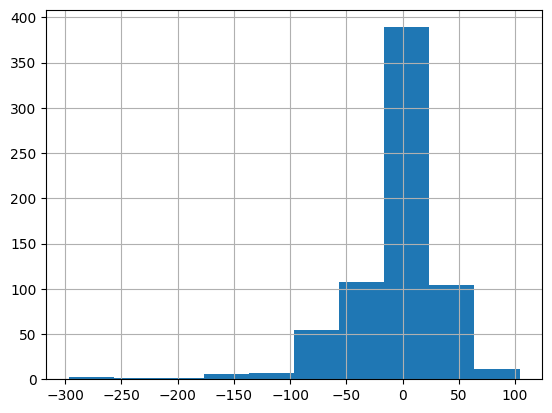

In [99]:
not_sc2ts_close["min_parent_branch_length"].hist()

<Axes: >

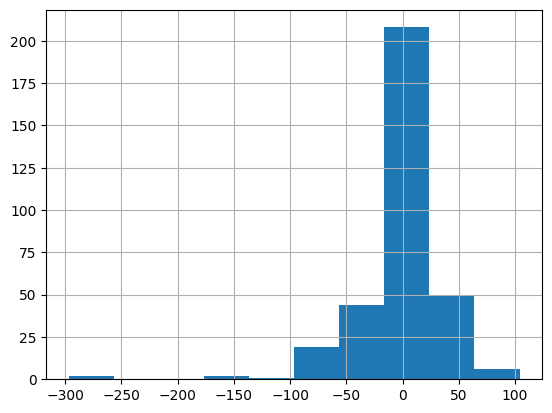

In [100]:
not_sc2ts_close[not_sc2ts_close["passes_3seq"]]["min_parent_branch_length"].hist()

In [104]:
sc2ts_should_find = not_sc2ts_close[not_sc2ts_close["passes_3seq"] & (not_sc2ts_close["min_parent_branch_length"] >0)
    & (not_sc2ts_close["sc2ts_num_mutations"] > 4)]
sc2ts_should_find

,parent1,parent2,recombinant_date,parent1_date,parent2_date,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,sc2ts_num_mutations,x_lineage_involved,usher_num_descendants,max_parent_date,min_parent_branch_length,passes_3seq
recombinant,,,,,,,,,,,,,,,,
SRR21173296,SRR16900296,ERR6634797,2021-10-27,2021-10-19,2021-08-26,{'AY.26': 1},685800,1,-1,2147483648,8,False,1,2021-10-19,8,True
ERR6629362,ERR6387573,ERR6203132,2021-08-08,2021-07-22,2021-06-20,{'AY.4': 1},402648,1,295320,4,5,False,1,2021-07-22,17,True
SRR20953902,SRR21175830,ERR6440908,2021-11-09,2021-10-26,2021-07-26,{'AY.119': 1},743713,1,-1,2147483648,7,False,1,2021-10-26,14,True
ERR7240684,ERR6922762,ERR6568434,2021-10-07,2021-09-27,2021-08-08,{'AY.4': 1},611140,1,-1,2147483648,6,False,1,2021-09-27,10,True
ERR7245663,ERR6922139,ERR6203132,2021-10-14,2021-09-27,2021-06-20,{'AY.4': 1},637273,1,295320,4,5,False,1,2021-09-27,17,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR16884218,SRR16782118,SRR16829649,2021-10-14,2021-10-13,2021-10-09,{'AY.103': 1},638820,1,-1,2147483648,5,False,1,2021-10-13,1,True
node_219459,SRR20116299,ERR7232760,2021-12-06,2021-12-02,2021-10-16,{'AY.39': 2},862835,2,-1,2147483648,7,False,2,2021-12-02,4,True
ERR7718295,ERR7386894,ERR6605289,2021-11-23,2021-11-05,2021-08-24,{'AY.4': 1},807228,1,-1,2147483648,7,False,1,2021-11-05,18,True


In [63]:
ts = tszip.load("../data/sc2ts_viridian_v1.2.trees.tsz")
df_node = sc2ts.node_data(ts)

2025-10-15 17:01:09,702 INFO:Computing inheritance counts


In [64]:
df_sample = df_node[df_node.is_sample].set_index("sample_id")

In [105]:
df_sample.loc[["SRR21173296", "SRR16900296", "ERR6634797"]]


,pango,scorpio,node_id,is_sample,is_recombinant,num_mutations,max_descendant_samples,date
sample_id,,,,,,,,
SRR21173296,AY.26,Delta (B.1.617.2-like),685800,True,False,8,1,2021-10-27
SRR16900296,AY.26,Delta (B.1.617.2-like),656285,True,False,1,1,2021-10-19
ERR6634797,AY.4.2,Delta (AY.4.2-like),449467,True,False,1,2,2021-08-26


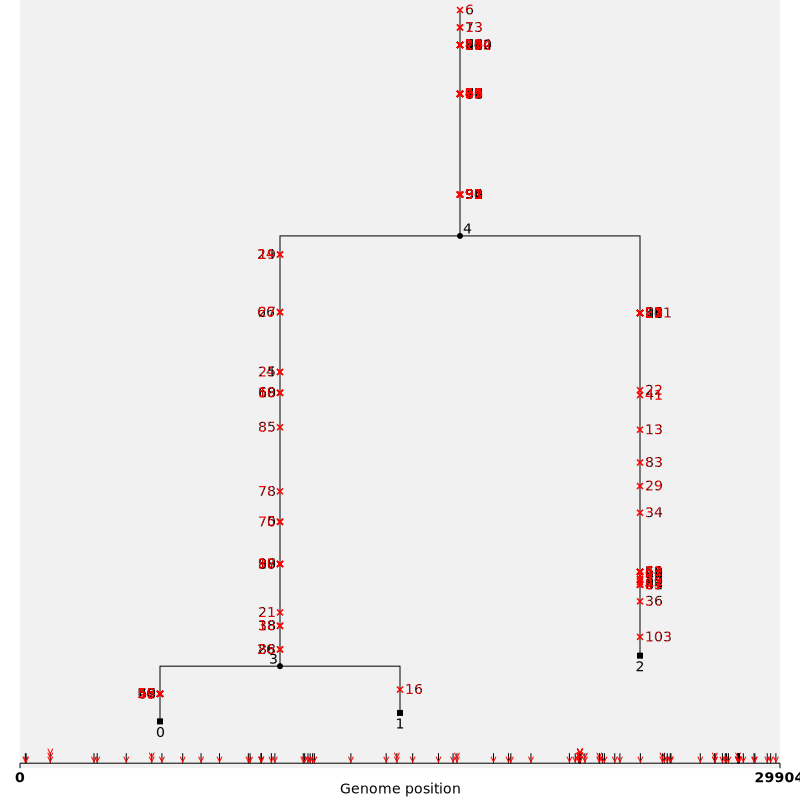

In [106]:
tss = ts.simplify([685800, 656285, 449467])
tss.draw_svg(size=[800, 800])

In [73]:
np.sum(tss.mutations_node == 3)

np.int64(53)

In [108]:
tss.tables.mutations[tss.mutations_node == 0]

id,site,node,time,derived_state,parent,metadata
0,39,0,508.04510269,T,-1,
1,40,0,508.04510269,G,-1,
2,41,0,508.04510269,A,48,
3,42,0,508.04510269,A,51,
4,43,0,508.04510269,A,54,
5,44,0,508.04510269,G,57,
6,45,0,508.04510269,T,60,
7,46,0,508.04510269,G,63,


In [109]:
tss.tables.mutations[tss.mutations_node == 1]

id,site,node,time,derived_state,parent,metadata
0,13,1,512.04510269,T,-1,


In [110]:
tss.tables.mutations[tss.mutations_node == 2]

id,site,node,time,derived_state,parent,metadata
0,2,2,867.15883591,C,2,
1,5,2,867.15883591,T,-1,
2,6,2,867.15883591,C,8,
3,8,2,867.15883591,T,-1,
4,9,2,867.15883591,T,-1,
5,10,2,757.08537715,T,-1,
6,11,2,867.15883591,T,-1,
7,12,2,867.15883591,T,-1,
8,17,2,867.15883591,T,-1,
9,19,2,794.39448572,G,-1,


In [112]:
ts.sites_position[range(39, 47)]

array([40., 41., 42., 43., 44., 45., 46., 47.])

In [115]:
tss.sites_position[tss.mutations_site[tss.mutations_node == 0]]

array([22026., 22027., 22029., 22030., 22031., 22032., 22033., 22034.])

In [120]:
recombinant_samples = [s for s in sc2ts_should_find.index if "node" not in s]
df_missing_recombinants = df_sample.loc[recombinant_samples]
df_missing_recombinants.shape

(73, 8)

In [121]:

df_mutation = sc2ts.mutation_data(ts)
df_mutation

2025-10-15 21:04:53,961 INFO:Computing inheritance counts


,mutation_id,position,parent,node,inherited_state,derived_state,date,num_descendants,num_inheritors
0,0,25,-1,644280,T,A,2021-09-20,1,1
1,1,38,-1,12915,A,G,2020-04-21,1,1
2,2,43,-1,344292,T,A,2021-07-17,3,3
3,3,43,-1,427855,T,C,2021-07-25,2,2
4,4,43,-1,670767,T,C,2021-08-21,2,2
...,...,...,...,...,...,...,...,...,...
2285339,2285339,29850,-1,691821,A,G,2021-10-18,1,1
2285340,2285340,29850,-1,719257,A,G,2021-10-21,2,2
2285341,2285341,29850,-1,952268,A,G,2021-12-13,5,5
2285342,2285342,29850,-1,1129360,A,G,2022-01-08,1,1


In [124]:
missing_recomb_mutations = df_mutation[df_mutation.node.isin(df_missing_recombinants.node_id)]
missing_recomb_mutations

,mutation_id,position,parent,node,inherited_state,derived_state,date,num_descendants,num_inheritors
13252,13252,192,-1,698148,G,T,2021-09-24,1,1
16855,16855,203,-1,861794,C,T,2021-10-09,1,1
36955,36955,323,-1,496345,G,A,2021-07-13,1,1
37155,37155,328,-1,569038,A,G,2021-08-02,1,1
44367,44367,364,-1,720507,C,A,2021-10-27,1,1
...,...,...,...,...,...,...,...,...,...
2192874,2192874,29734,-1,644234,G,A,2021-09-14,1,1
2250688,2250688,29779,-1,448341,G,T,2021-07-23,1,1
2254867,2254867,29779,-1,639016,G,T,2021-10-07,1,1
2258294,2258294,29779,-1,790418,G,T,2021-11-10,1,1


In [125]:
missing_recomb_mutations["position"].value_counts()

position
22027    27
22031    27
22030    27
22029    27
22032    27
         ..
29422     1
29580     1
29540     1
29734     1
29781     1
Name: count, Length: 245, dtype: int64

In [128]:
remap_sites = pd.read_csv("../arg_postprocessing/sc2ts_v1_2023-02-21_pr_pp_sites_to_remap.csv")
remap_sites

,position,reason
0,203,pango
1,222,pango
2,335,pango
3,337,pango
4,683,pango
...,...,...
158,29762,pango
159,29769,pango
160,29774,pango
161,29779,pango


In [130]:
np.sum(missing_recomb_mutations["position"].isin(remap_sites["position"]))

np.int64(192)